In [252]:
#The goal of the job is to create models to predict prices of houses and appartments in Capital Federal, Argentina.
#Diferent models will be performed and then the best one will be selected. 
#The models proposed are:
#Linear Regression
#KNN
#Decision trees (using Random Forest and boosting methods)

#The best model will be that one with the lowest RMSE on the test dataframe 

#Libraries

#Pre-processing data and data selection
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Statatistic tests
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import norm

#Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import multiprocessing

#Graphics
import matplotlib.pyplot as plt

In [209]:
#Functions

#Remove outliers
def remove_outliers(dataframe,column):
    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)
    iqr = q3-q1
    
    dataframe_2 = dataframe[(dataframe[column] > q1-1.5*iqr ) | (dataframe[column] < q3+1.5*iqr)]
    return(dataframe_2)
        
    
#RMSE function returns the Root Mean Square Error between the prediction and its real value
def RMSE(predict,real_value):
    error = predict - real_value
    RMSE = ((error**2).mean())**(1/2)
    
    return(np.round(RMSE))

In [210]:
#The data was previously downloaded from the Properati Web site
#The dataset that we are using during the job is called 'Properati'
properati = pd.read_csv("/Users/user/Desktop/Data Scientis R Python SQL/Datasets/Precio inmuebles/properati_python.csv")

In [211]:
#Unnecessary columns are removed
properati = properati.drop(["Unnamed: 0","ad_type","start_date","l1","l2","l5","l6","currency","price_period","operation_type","title"],axis = 1)

In [212]:
properati

,lat,lon,l3,l4,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
0,-34.638910,-58.476073,Floresta,NaN,NaN,NaN,NaN,372.0,NaN,450000.0,"Lote 365 mts 8,90 x 43 mts C3 II.. FOT 3.6 PAR...",Lote
1,-34.562124,-58.464449,Belgrano,NaN,NaN,NaN,NaN,NaN,NaN,20000.0,"Muy buena cochera, en el 4to piso en excelente...",Cochera
2,-34.598112,-58.400784,Recoleta,NaN,NaN,NaN,3.0,265.0,265.0,600000.0,Gran Oportunidad! Unica piso de oficinas de 26...,Oficina
3,-34.614123,-58.378985,Monserrat,NaN,5.0,NaN,3.0,150.0,150.0,195000.0,Importante Oficina de de 150 m2 con palier pr...,Oficina
4,-34.603233,-58.385218,San Nicolás,NaN,1.0,NaN,1.0,NaN,12.0,22000.0,VENTA DE OFICINA A METROS DEL PALACIO DE TRIBU...,Oficina
...,...,...,...,...,...,...,...,...,...,...,...,...
180413,-34.613926,-58.499472,Monte Castro,NaN,6.0,5.0,2.0,243.0,180.0,250000.0,Corredor Responsable: Rene Vera - CUCICBA 6778...,PH
180414,-34.570592,-58.462513,Belgrano,NaN,9.0,5.0,6.0,641.0,461.0,1650000.0,Casa en pleno Belgrano R reciclada con excelen...,Casa
180415,-34.573074,-58.419353,Palermo,NaN,8.0,5.0,3.0,419.0,375.0,1350000.0,Piso de 419 m2 en un emblemático edificio mode...,Departamento
180416,-34.563411,-58.445656,Belgrano,NaN,6.0,5.0,4.0,285.0,270.0,1400000.0,"Piso de 285mts, en la mejor zona de Belgrano.<...",Departamento


In [213]:
print(f'The Properati dataset has {properati.shape[1]} columns and {properati.shape[0]} rows')

The Properati dataset has 12 columns and 180418 rows


In [214]:
#Pre-processing data: On Properati dataframe the data will be precessed in order to get the final one which will be used to create the models. 

##Before start to clear the data let's to explain the columns in the dataframe:
#Bathrooms: Number of bathrooms in the property
#Room: Number of rooms in the property
#Bedroom: Number of bedrooms in the property
#l3 and l4 are the suburb where the property is located where l4 shows a more precise zone
#property_type: Is the type of the property. House, appartment or PH
#lat and lon: Coordinates where the property is located
#surface_total: Total surface in the house
#surface_covered: Surface covered in the house
#Price: The price of the property


In [215]:
#Detection of NA values in the dataframe. Columns 'lat' , 'lon' , 'rooms' , 'bedrooms' , 'bathroos' , 'surface_total' and 'surface_covered' have NA values and will be imputed
properati.isnull().sum()

lat                 11125
lon                 11125
l3                   1676
l4                 173404
rooms               26908
bedrooms            48415
bathrooms           24055
surface_total       60254
surface_covered     61739
price                   0
description             0
property_type           0
dtype: int64

In [216]:
#'l3'  and 'l4' columns indicate suburb in Capital Federal, where 'l4' gives more specific location than 'l4'. Both will be passed as character and then merged. The values in 'l4' column will replace values in 'l3' column
properati['suburb' ] = np.where(properati['l4'].isin(properati['l4'].unique()[1:5]),
         properati['l4'],
         properati['l3'])

#'l3' and 'l4' column are no longer needed
properati = properati.drop(['l3','l4'], axis = 1)


In [217]:
#Records without suburb are removed
properati = properati[properati['suburb'].notnull()]

In [218]:
#The dataframe only will contain records of houses and appartments, so any other factor in 'property_type' will be removed
properati = properati[properati['property_type'].isin(['Casa','Departamento','PH'])]


In [219]:
#Let's transform first string to lower case
properati["description"] = properati["description"].str.lower()

#The column 'description' is the description made by the seller in the Properati Web. There is valuable information that could be interesting to get, so if the publication has a garage, backyard, balcony, if it's new, if it's furnished or if it has amenities will be added as boolean columns in the dataframe 
properati['garage'] = np.where(properati["description"].str.contains("cochera|estacioneminto|arage|parking"),1,0)
properati['backyard'] = np.where(properati["description"].str.contains("patio|jardin"),1,0)
properati['balcony'] = np.where(properati["description"].str.contains("balcon|balcón"),1,0)
properati['new'] = np.where(properati["description"].str.contains("nuevo|estrenar"),1,0)
properati['furnished'] = np.where(properati["description"].str.contains("amoblado|mueble|muebles"),1,0)
properati['amenities'] = np.where(properati["description"].str.contains("sum|s.u.m|parrilla|jacuzzi"),1,0)




In [220]:
#Column 'description' is no longer needed
properati = properati.drop('description', axis = 1)


In [221]:
#There are incomplete records that most of their values ara NA and hard to imputed, so will be removed
properati = properati[ (properati['bedrooms'].isnull() &  properati['rooms'].isnull() & properati['bathrooms'].isnull())==False]

properati = properati[(properati['bedrooms'].isnull() &  properati['rooms'].isnull() & properati['surface_total'].isnull() & properati['surface_covered'].isnull())==False]

properati = properati[(((properati.bedrooms == 0)  & (properati.rooms == 1)) | (properati.bedrooms > 0)  | (properati.bedrooms.isnull()))]


In [222]:
#Before start to impute values the outliers are removed in order to don't distort the values
properati = properati[(properati.rooms <= 7) | (properati.rooms.isnull())]
properati = properati[(properati.bedrooms <= 6) | (properati.bedrooms.isnull())]
properati = properati[(properati.bedrooms >= 0) | (properati.bedrooms.isnull())]
properati = properati[(properati.bathrooms <= 3) | (properati.bathrooms.isnull())]
properati = properati[properati.price > 0]
properati = properati[properati.price <= 437200]
properati = properati[(properati.surface_total <= 150) | (properati.surface_total.isnull())]
properati = properati[(properati.surface_covered <= 119) | (properati.surface_covered.isnull())]


In [223]:
#Imputation of latitude and longitude: There are records where the coordinates are inconsistent with the coordinates of Capital Federal and also, NA values. So they will be imputed by the average of the coordinates of the suburb to which they belong

#LATITUDE
lat_mean_bySuburb = properati.groupby('suburb')['lat'].mean()
lat_missing_index = properati[(((properati.lat < -33) & (properati.lat > -35)) | properati.lat.notnull())==False].index

for i in lat_missing_index:
    properati.loc[i,'lat']= lat_mean_bySuburb[properati.suburb[i]]

#LONGITUDE    
lon_mean_bySuburb = properati.groupby('suburb')['lon'].mean()
lon_missing_index = properati[(((properati.lon < -57) & (properati.lon > -59)) | properati.lon.notnull())==False].index

for i in lon_missing_index:
    properati.loc[i,'lon']= lon_mean_bySuburb[properati.suburb[i]]

    

In [224]:
#'Bedroom' column imputation: Houses and apartments with NA values in 'Bedroom' column are assumed to have one less unit than the 'Room' column
for i in properati[(properati.bedrooms.isnull()) & (properati.rooms.notnull())].index:
         properati.loc[i,'bedrooms'] = properati.rooms[i] - 1
    
for i in properati[properati.bedrooms.isnull()].index:
    
    properati.loc[i,'bedrooms'] = np.where(properati.loc[i,'bathrooms'] == 1,1,
                                          np.where(properati.loc[i,'bathrooms'] == 2,2,
                                                  np.where(properati.loc[i,'bathrooms'] == 3,3,
                                                          properati.loc[i,'bathrooms'])))
    
#In the same way, records with NA values in 'Room' column are assumed to have one more unit than the 'Bedroom' column 
for i in properati[(properati.rooms.isnull()) & (properati.bedrooms.notnull())].index:
         properati.loc[i,'rooms'] = properati.bedrooms[i] + 1
    



In [225]:

#'Bathroom' column imputation: By majority rule is assumed that bethrooms with at least two bedrooms have one bathroom and that ones with more than 2 bedrooms have 2 bathrooms. So NA values in 'Bathroom' column are imputed using that rule.
properati.bathrooms = np.where((properati.bathrooms.isnull()) & (properati.bedrooms <= 2),
         1,
         np.where((properati.bathrooms.isnull()) & (properati.bedrooms > 2),
                 2,
                  properati.bathrooms))



In [226]:
#Surface columns imputation: There are records when don't provide values in Total Surface column but it is in the Covered Surface' column and vice versa. Then, for the missing value, the value of the other column will be taken.

properati.surface_covered = np.where((properati.surface_covered.isnull()) & (properati.surface_total.notnull()),
         properati.surface_total,
         properati.surface_covered)

properati.surface_total = np.where((properati.surface_total.isnull()) & (properati.surface_covered.notnull()),
         properati.surface_covered,
         properati.surface_total)

#There are records where the total surface is lower than the covered one, so those ones will be assumed that the total surface is the same than the covered one.
properati.surface_total = np.where((properati.surface_total<properati.surface_covered),
         properati.surface_covered,
         properati.surface_total)



In [227]:
#'rooms', 'bedrooms' and 'bathrooms' columns are converted to string
properati.rooms = properati.rooms.astype(str)
properati.bedrooms = properati.bedrooms.astype(str)
properati.bathrooms = properati.bathrooms.astype(str)

In [228]:
#For records without values on the surface, the average will be imputed depending on the number of rooms, bedrooms and bathrooms

properati['index'] = properati['rooms'] + ", "+ properati['bedrooms'] +", "+  properati['bathrooms']

index_to_delete = properati.groupby(['index'])['surface_total'].sum()[properati.groupby(['index'])['surface_total'].mean().isnull()].index

properati = properati[properati['index'].isin(index_to_delete) == False]

surface_mean_byRooms = pd.DataFrame(properati[properati.surface_total.notnull()].groupby(['rooms','bedrooms','bathrooms'])['surface_total'].mean())

surface_total_missing_index = properati[properati.surface_total.isnull()].index

for i in surface_total_missing_index:

    properati.loc[i, 'surface_total'] = surface_mean_byRooms[surface_mean_byRooms.index == (properati.rooms[i], properati.bedrooms[i], properati.bathrooms[i])].iloc[0][0]

                                      
#As assumption the same value imputed to 
properati.surface_covered = np.where(properati.surface_covered.isnull(),
         properati.surface_total,
         properati.surface_covered)


                     

In [229]:
#A new column is added that indicate the average price of the houses and apartments for the suburb where are located, and the quantity of rooms, bedrooms and bathrooms that has it.
price_mean_bySuburb = pd.DataFrame(properati.groupby(['suburb','rooms','bedrooms','bathrooms','property_type'])['price'].mean().round(0))


for i in  properati.index:
    properati.loc[i, 'price_mean'] = price_mean_bySuburb[price_mean_bySuburb.index == (properati.suburb[i],properati.rooms[i],properati.bedrooms[i],properati.bathrooms[i],properati.property_type[i])].iloc[0][0]
         

In [230]:
#'rooms', 'bedrooms' and 'bathrooms' columns are converted to float in order to detect high correlation between the numeric features
properati.rooms = properati.rooms.astype(float)
properati.bedrooms = properati.bedrooms.astype(float)
properati.bathrooms = properati.bathrooms.astype(float)

#The correlation matrix shows the correlationship between  the features
#The features 'bedrooms' and 'surface_covered' are highly correlated  with rooms. so, both features are removed 
(properati.select_dtypes(float)).corr(method='pearson')>0.75 

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_mean
lat,True,False,False,False,False,False,False,False,False
lon,False,True,False,False,False,False,False,False,False
rooms,False,False,True,True,False,True,True,False,False
bedrooms,False,False,True,True,False,True,True,False,False
bathrooms,False,False,False,False,True,False,False,False,False
surface_total,False,False,True,True,False,True,True,False,False
surface_covered,False,False,True,True,False,True,True,False,True
price,False,False,False,False,False,False,False,True,True
price_mean,False,False,False,False,False,False,True,True,True


In [231]:
properati = properati.drop(['bedrooms','surface_covered'],axis = 1)

In [232]:
#The features 'rooms' and 'bathrooms' are converted to string 
properati.rooms = properati.rooms.astype(str)
properati.bathrooms = properati.bathrooms.astype(str)

In [233]:
#The string features are converted as dummy variables and then merged to the numeric variables
dummy = pd.get_dummies(properati[['rooms','bathrooms']])
no_dummy = properati[['lat','lon','surface_total','price','price_mean','garage','backyard','balcony','new','furnished','amenities']]

properati_dummy = pd.concat([no_dummy,dummy], axis=1)


In [234]:
#Near Zero Variable will be performed the diagnoses predictors without variance 
selector = VarianceThreshold(0)

selector.fit(properati.select_dtypes(float))

#There are not predictors without variance, so no predictors are removed 
properati.select_dtypes(float).loc[:,selector.get_support()]


,lat,lon,surface_total,price,price_mean
11,-34.600004,-58.417191,38.000000,110000.0,89795.0
12,-34.581699,-58.433547,35.000000,105000.0,113110.0
13,-34.595044,-58.442538,51.000000,150000.0,150352.0
14,-34.582549,-58.417350,53.000000,136500.0,150352.0
15,-34.578497,-58.424945,30.000000,139000.0,108265.0
...,...,...,...,...,...
180395,-34.606393,-58.457272,85.000000,160000.0,160000.0
180396,-34.627756,-58.403768,90.500000,325000.0,325000.0
180407,-34.550627,-58.453145,95.000000,109000.0,109000.0
180410,-34.614237,-58.394551,111.687316,235000.0,185158.0


In [235]:
#Data splitting: The dataset is spplited into training and testing data

train, test = train_test_split(properati_dummy, test_size=0.25, random_state=25)

#x = 'lat', 'lon', 'surface_total', 'price_mean', 'garage', 'backyard','balcony', 'new', 'furnished', 'amenities', 'rooms','bathrooms'
#y = 'price

x_train = train.copy()
x_train = x_train.drop(['price'], axis = 1)
y_train = train.price.copy()

x_test = test.copy()
x_test = x_test.drop(['price'], axis = 1)
y_test = test.price.copy()


In [236]:
#Scaler: The numeric columns in the dataframe are scaled in order to create the models. 

scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

In [237]:
#Linear Regression model: The model will be performed using the price as the outcome and the rest of the variables as the predictors

lm_model = sm.OLS(y_train, x_train).fit()
lm_model.summary()

#The model summaty shows the individuals test of significance for each feature. 
#The P-value for all of them is under 0.05, so there is no evidence to remove them for the model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                 1.604e+04
Date:                Fri, 10 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:07:17   Log-Likelihood:            -1.1228e+06
No. Observations:               93501   AIC:                         2.246e+06
Df Residuals:                   93482   BIC:                         2.246e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
lat            7.449e+04   3.24e+04      2.301      0.021     1.1e+04    1.38e+05
lon            1.943e+05   4.82e+04      4.029      0.000    9.98e+04    2.89e+05
surface_total  1.973e+05   1429.140    138.083      0.000    1.95e+05       2e+05
price_mean     3.708e+05   1601.777    231.485      0.000    3.68e+05    3.74e+05
garage         2.446e+04    307.598     79.530      0.000    2.39e+04    2.51e+04
backyard      -3837.7993    356.795    -10.756      0.000   -4537.113   -3138.486
balcony        6663.4006    279.283     23.859      0.000    6116.009    7210.792
new            1122.1390    324.958      3.453      0.001     485.225    1759.053
furnished      -554.6703    264.378     -2.098      0.036   -1072.849     -36.492
amenities      9199.7595    288.150     31.927      0.000    8634.988    9764.531
rooms_1.0     -2.097e+04   6784.140     -3.092      0.002   -3.43e+04   -7677.434
rooms_2.0     -3.179e+04   6772.643     -4.693      0.000   -4.51e+04   -1.85e+04
rooms_3.0     -5.274e+04   6771.319     -7.789      0.000    -6.6e+04   -3.95e+04
rooms_4.0     -6.907e+04   6780.961    -10.186      0.000   -8.24e+04   -5.58e+04
rooms_5.0     -7.704e+04   6836.488    -11.269      0.000   -9.04e+04   -6.36e+04
rooms_6.0     -6.644e+04   7152.233     -9.289      0.000   -8.05e+04   -5.24e+04
rooms_7.0     -7.561e+04   7804.587     -9.688      0.000   -9.09e+04   -6.03e+04
bathrooms_1.0 -1.131e+05   1.58e+04     -7.179      0.000   -1.44e+05   -8.22e+04
bathrooms_2.0 -1.345e+05   1.58e+04     -8.537      0.000   -1.65e+05   -1.04e+05
bathrooms_3.0  -1.46e+05   1.58e+04     -9.256      0.000   -1.77e+05   -1.15e+05
==============================================================================
Omnibus:                    12547.658   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39745.045
Skew:                           0.697   Prob(JB):                         0.00
Kurtosis:                       5.873   Cond. No.                     1.10e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.81e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0, 0.5, 'Predicted')

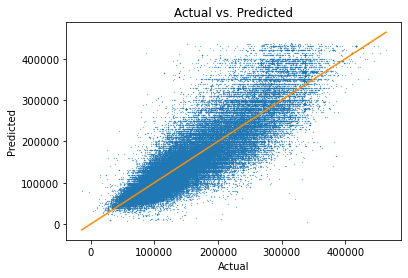

In [238]:
#Linearity
#This assumes that there is a linear relationship between the predictors and the response variable

#Could be detected by using a scatter plot to see the predicted values versus the actual values (in other words, view the residuals).
#Ideally, the points should lie on or around a diagonal line on the scatter plot.
line = np.arange(lm_model.fittedvalues.min(),lm_model.fittedvalues.max())

# Plot outputs
plt.scatter(lm_model.fittedvalues, y_train, color="#1f77b4", s = 0.05)
plt.plot(line,line,'darkorange')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')



#We can see in this case that there is not a perfect linear relationship. 
#OuTher predictions are biased towards higher values #Li

In [239]:
#Normality of the Error Terms

#This assumes that the error terms of the model are normally distributed.
#A violation of this assumption could cause issues with either shrinking or inflating our confidence intervals.

#The histogram of the residuals and the p-value from the Anderson-Darling test could be performed to detect the normality.

#Anderson-Darling test
print(f'p-value: {normal_ad(lm_model.resid)[1]} < 0.05, the residuals are non normal')

p-value: 0.0 < 0.05, the residuals are non normal


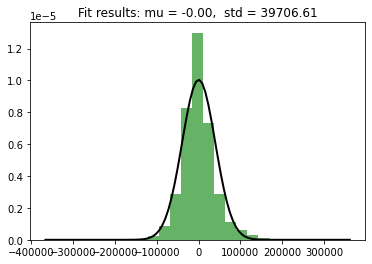

In [240]:
#Histogram of the residuals

# Fit a normal distribution to the data:
mu, std = norm.fit(lm_model.resid)

# Plot the histogram.
plt.hist(lm_model.resid, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

#This isn’t ideal, and we can see that our model is biasing towards under-estimating.

In [241]:
#No Autocorrelation of the Error TermsPermalink
#This assumes no autocorrelation of the error terms. 
#Autocorrelation being present typically indicates that we are missing some information that should be captured by the model

#We will perform a Durbin-Watson test to determine if either positive or negative correlation is present.
#Also, could be detected by ploting the residual autocorrelations 

#Durbin-Watson test

print(f'The Durbin-Watson test is {durbin_watson(lm_model.resid).round(3)}. Little to no autocorrelation')



The Durbin-Watson test is 1.996. Little to no autocorrelation


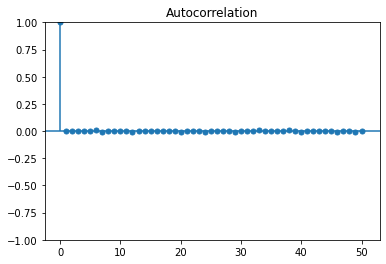

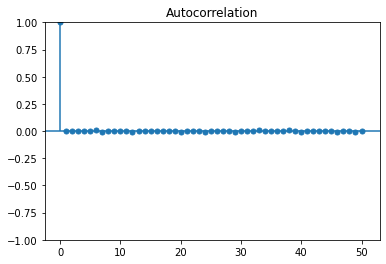

In [242]:
#Autocorrelation plot
plot_acf(lm_model.resid)


#The estimation of the coeficient for each delay are near to 0,so the residuals are not corelated

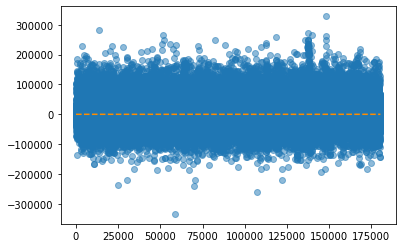

In [243]:
#Homoscedasticity

#This assumes homoscedasticity, which is the same variance within our error terms. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms.

#To detect it, the variance of the residuals must to be uniform
plt.scatter(x=lm_model.resid.index, y=lm_model.resid, alpha=0.5)
plt.plot(np.repeat(0, lm_model.resid.index.max()), color='darkorange', linestyle='--')


#We can’t see a fully uniform variance across our residuals, so this is potentially problematic.


In [244]:
#Linearity, Normality and Homoscedasticity assumptions are violated, so the predictions will be extremely inaccurate because our model is underfitting.
#The linear regression is not a model to predict the prices


In [245]:
#KNN Model: KNN is simple model that identifies observations in the training set that are similar to the test observation and evaluates the prevalling value as a prediction. There are no assumptions since it is a non-parametric model. 

#Using cross-validation with 10 folders and taking a grid of 6 values for the  parameter "K"

#Choose k 
k_grid = [1,3,5,15,25,30]

knn_scores = pd.DataFrame(index = range(0, 5), columns=['K','RMSE'])
j = 0

# use iteration to caclulator different k in models, then return the average of the values based on the cross validation
for i in k_grid:
    
    knn = KNeighborsClassifier(n_neighbors=i)

    scores = cross_val_score(knn,
                             x_train,
                             y_train,
                             cv=10,
                             scoring = 'neg_root_mean_squared_error')
    
    knn_scores.loc[j,'K'] = i
    knn_scores.loc[j,'RMSE'] = scores.mean()*-1
    
    j = j+1
    

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than 

Text(0, 0.5, 'RMSE')

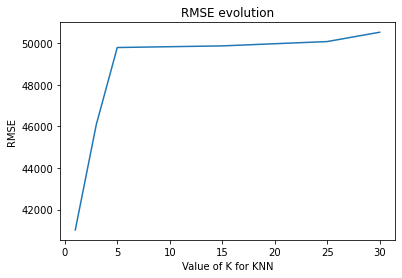

In [246]:
#The graphic shows the evolution of the RMSE when the K parameter increases
#The best KNN model involve a k = 1

plt.plot(knn_scores.K, knn_scores.RMSE)
plt.title('RMSE evolution')
plt.xlabel('Value of K for KNN')
plt.ylabel('RMSE')


In [255]:
#Final KNN model
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [256]:
#Decision Tree models: The prediction could be improved by performing Desicion Tree models, in this analysis we will use Random Forest and Boosting mehtods.

Text(0, 0.5, 'RMSE')

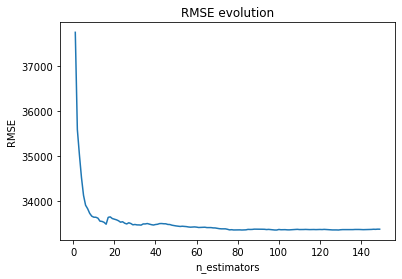

In [257]:
#Random Forest: The importance of this method is to reduce the variance of the model, 

#Hhe model parameters are evaluated separately to see how the model behaves as the parameter takes different values

#n_jobs: A range of 150 trees are performed to detect where is the number of  the iteration where the RMSE is constant

train_scores = []

for i in range(1,150,1):
    random_forest_initial = RandomForestRegressor(
                    n_estimators=i,
                      criterion='squared_error',
                      n_jobs=multiprocessing.cpu_count() - 1,
                      max_features='sqrt',
                      min_samples_split=10,
                      min_samples_leaf=20,
                      bootstrap=True,
                     random_state = 1234)
    
    random_forest_initial.fit(x_train,y_train)
    train_scores.append(RMSE(random_forest_initial.predict(x_train),y_train))

plt.plot(range(1,150,1), train_scores)
plt.title('RMSE evolution')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")

#After the iteration 60 the RMSE is decreasing slowly. The parameter 'n_estimators' is set to 60 iterations

Text(0, 0.5, 'RMSE')

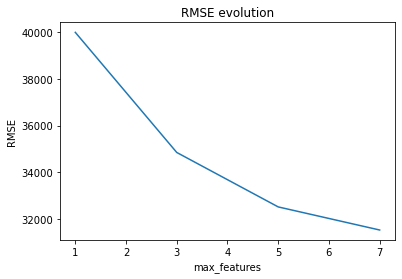

In [259]:
#max_features: A range of 8 values  are taken for the hyperparameter

train_scores = []

for i in range(1,8,2):
    random_forest_initial = RandomForestRegressor(
                    n_estimators=60,
                      criterion='squared_error',
                      n_jobs=multiprocessing.cpu_count() - 1,
                      max_features=i,
                      min_samples_split=10,
                      min_samples_leaf=20,
                      bootstrap=True,
                     random_state = 1234)
    
    random_forest_initial.fit(x_train,y_train)
    train_scores.append(RMSE(random_forest_initial.predict(x_train),y_train))

plt.plot(range(1,8,2), train_scores)
plt.title('RMSE evolution')
plt.xlabel("max_features")
plt.ylabel("RMSE")

#The RMSE decreases slowly where the parameter 'max_features' is 8.

Text(0, 0.5, 'RMSE')

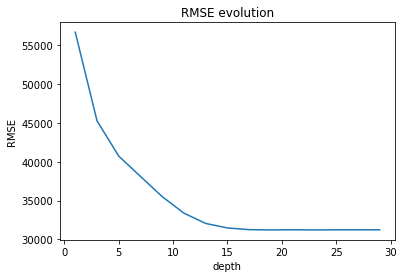

In [260]:
#max_depth: A range between 1 and 30 is taken for the hyperparameter

train_scores = []

for i in range(1,30,2):
    random_forest_initial = RandomForestRegressor(
                    n_estimators=60,
                      criterion='squared_error',
                      n_jobs=multiprocessing.cpu_count() - 1,
                      max_features=8,
                      max_depth=i,
                      min_samples_split=10,
                      min_samples_leaf=20,
                      bootstrap=True,
                     random_state = 1234)
    
    random_forest_initial.fit(x_train,y_train)
    train_scores.append(RMSE(random_forest_initial.predict(x_train),y_train))

plt.plot(range(1,30,2), train_scores)
plt.title('RMSE evolution')
plt.xlabel("depth")
plt.ylabel("RMSE")

#The RMSE decreases slowly where the parameter 'max_depth' is 15.

In [261]:
#Once the most important hyperparameters are set let's perform a grid to select other hyperparameters.

ranfom_forest_param_grid = {'min_samples_split'  : [5,10,20,30,50],
                            'min_samples_leaf'   : [5,10,20,30,50]}


random_forest_grid = GridSearchCV(
        estimator  = RandomForestRegressor(
                    n_estimators=50,
                      criterion='squared_error',
                      n_jobs=multiprocessing.cpu_count() - 1,
                      max_features=14,
                      max_depth=15,
                      bootstrap=True,
                     random_state = 1234),
        param_grid = ranfom_forest_param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=10, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

random_forest_grid.fit(x_train,y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=10, random_state=123),
             estimator=RandomForestRegressor(max_depth=15, max_features=14,
                                             n_estimators=50, n_jobs=7,
                                             random_state=1234),
             n_jobs=7,
             param_grid={'min_samples_leaf': [5, 10, 20, 30, 50],
                         'min_samples_split': [5, 10, 20, 30, 50]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [262]:
#The final and best Random Forest Model is reached
random_forest_best_model = random_forest_grid.best_estimator_

Text(0, 0.5, 'Feature')

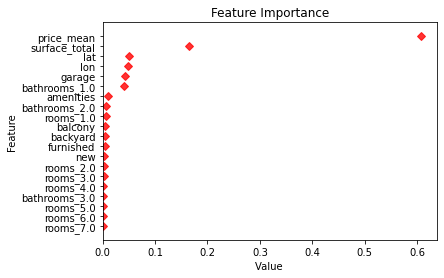

In [263]:
#Random forest model allows to represent graphicly the feature importance in the model

random_forest_FeatImp = pd.DataFrame({'feature' : test.columns.drop('price'),
             'importance' : random_forest_best_model.feature_importances_}).sort_values(['importance'], ascending=True)

plt.barh(
    random_forest_FeatImp['feature'],
    random_forest_FeatImp['importance'],

    align='center',
    alpha=0
)
plt.plot(
    random_forest_FeatImp['importance'],
    random_forest_FeatImp['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)

plt.title('Feature Importance')
plt.xlabel("Value ")
plt.ylabel("Feature")

#The 'price_mean' and 'surface_total' are the most important feature to predict the prices

Text(0, 0.5, 'RMSE')

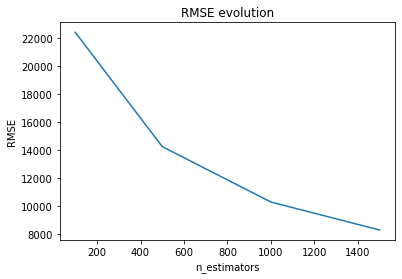

In [265]:
#GBM (Gradient Boost Machine): Another method is the GBM available in scikit learn.
#The hyperparameters are evaluated individualy

#n_estimators: A range of 5 values are evaluated to find how many iterations are necessary
train_scores = []
range_values = [100,500,1000,1500]

for i in range_values:
    
    gbm_initial = GradientBoostingRegressor(
        n_estimators = i,
        loss         = 'squared_error',
        max_features='auto',
        max_depth=10,
        learning_rate=0.1,
        random_state = 123)
    
    gbm_initial.fit(x_train,y_train)
    train_scores.append(RMSE(gbm_initial.predict(x_train),y_train))

plt.plot(range_values, train_scores)
plt.title('RMSE evolution')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")

#After 1000 iterations the RMSE is decreasing slowly. That value is taken to avoid the overfitting

Text(0, 0.5, 'RMSE')

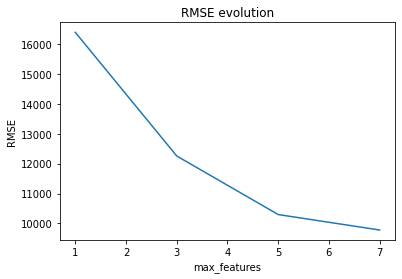

In [266]:
#max_features: A range of 8 values  are taken for the hyperparameter

train_scores = []
range_values = range(1,8,2)

for i in range_values:
    
    gbm_initial = GradientBoostingRegressor(
        n_estimators = 1000,
        loss         = 'squared_error',
        max_features= i ,
        max_depth=10,
        learning_rate=0.1,
        random_state = 123)
    
    gbm_initial.fit(x_train,y_train)
    train_scores.append(RMSE(gbm_initial.predict(x_train),y_train))

plt.plot(range_values, train_scores)
plt.title('RMSE evolution')
plt.xlabel("max_features")
plt.ylabel("RMSE")

#The RMSE decreases slowly where the parameter 'max_features' is 5.

Text(0, 0.5, 'RMSE')

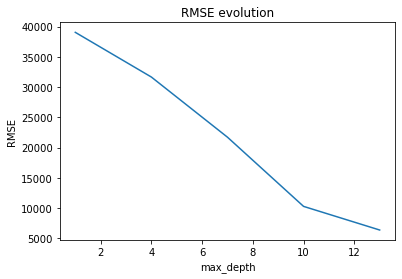

In [269]:
#max_depth: A range between 1 and 30 values are taken to find the hyperparameter

train_scores = []
range_values = range(1,15,3)

for i in range_values:
    
    gbm_initial = GradientBoostingRegressor(
        n_estimators = 1000,
        loss         = 'squared_error',
        max_features= 5 ,
        max_depth = i,
        learning_rate=0.1,
        random_state = 123)
    
    gbm_initial.fit(x_train,y_train)
    train_scores.append(RMSE(gbm_initial.predict(x_train),y_train))

plt.plot(range_values, train_scores)
plt.title('RMSE evolution')
plt.xlabel("max_depth")
plt.ylabel("RMSE")

#The RMSE decreases slowly where the parameter 'max_depth' is 10.

Text(0, 0.5, 'RMSE')

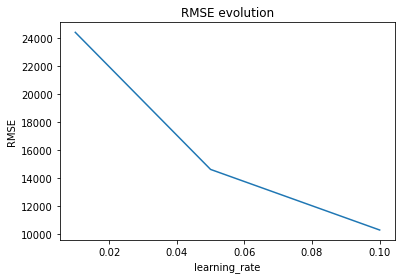

In [270]:
#learning_rate: The learning rate is evaluated by setting 5 different values

train_scores = []
range_values = [0.1,0.05,0.01]

for i in range_values:
    
    gbm_initial = GradientBoostingRegressor(
        n_estimators = 1000,
        loss         = 'squared_error',
        max_features= 5 ,
        max_depth=10,
        subsample = 1,
        learning_rate=i,
        random_state = 123)
    
    gbm_initial.fit(x_train,y_train)
    train_scores.append(RMSE(gbm_initial.predict(x_train),y_train))

plt.plot(range_values, train_scores)
plt.title('RMSE evolution')
plt.xlabel("learning_rate")
plt.ylabel("RMSE")

#The best learning ratio is 0.050

In [271]:
#The best model searched by RMSE envolves a number of 1000 trees, a depth of 13, a shrinkage of 0.05 and a depth of  13

gbm_final = GradientBoostingRegressor(
        n_estimators = 1000,
        loss         = 'squared_error',
        max_features= 6 ,
        max_depth=13,
        learning_rate=0.05,
        random_state = 123)
    
gbm_final.fit(x_train,y_train)


GradientBoostingRegressor(learning_rate=0.05, max_depth=13, max_features=6,
                          n_estimators=1000, random_state=123)

Text(0, 0.5, 'Feature')

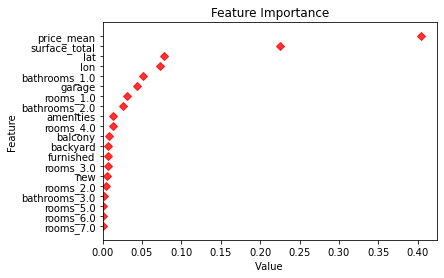

In [272]:
#The GBM model also allows to graphically represent the importance of features in the model.


gbm_FeatImp = pd.DataFrame({'feature' : test.columns.drop('price'),
             'importance' : gbm_final.feature_importances_}).sort_values(['importance'], ascending=True)

plt.barh(
    gbm_FeatImp['feature'],
    gbm_FeatImp['importance'],

    align='center',
    alpha=0
)
plt.plot(
    gbm_FeatImp['importance'],
    gbm_FeatImp['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)

plt.title('Feature Importance')
plt.xlabel("Value ")
plt.ylabel("Feature")

#The 'price_mean' and 'surface_total' are the most important feature to predict the prices

In [273]:
#Best Model Selection: The GBM model is that one with the lowest RMSE in both training and testing dataframes and also is that one with the higher R squared and is the model selected to predict the prices in Capital Federal.


best_model = {
    'Model': ['Linear Regression',
              'KNN',
              'Random Forest', 
              'GBM'],
    'Score': [lm_model.rsquared.round(3),
              knn_model.score(x_train,y_train).round(3),
             random_forest_best_model.score(x_train,y_train).round(3),
             gbm_final.score(x_train,y_train).round(3)],
    'RMSE train': [RMSE(lm_model.predict(x_train),y_train),
                  RMSE(knn_model.predict(x_train),y_train),
                  RMSE(random_forest_best_model.predict(x_train),y_train),
                  RMSE(gbm_final.predict(x_train),y_train)],
    'RMSE test':  [RMSE(lm_model.predict(x_test),y_test),
                  RMSE(knn_model.predict(x_test),y_test),
                  RMSE(random_forest_best_model.predict(x_test),y_test),
                  RMSE(gbm_final.predict(x_test),y_test)]
}

pd.DataFrame(best_model)



,Model,Score,RMSE train,RMSE test
0,Linear Regression,0.755,39707.0,39787.0
1,KNN,0.861,8841.0,41487.0
2,Random Forest,0.901,25224.0,30901.0
3,GBM,0.992,7210.0,27625.0
